# Vehicle detection

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2
import json

slim = tf.contrib.slim

C:\Users\alex\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\alex\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\alex\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\alex\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

In [4]:
isess = tf.InteractiveSession()

# Drawing and plotting routines.

In [22]:
def bboxes_draw_on_img(img, scores, bboxes, colors, thickness=2, show_text=True):
    """Drawing bounding boxes on an image, with additional text if wanted...
    """
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[i % len(colors)]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
#         if show_text:
#             s = '%s: %s' % ('Car', scores[i])    
#             p1 = (p1[0]-5, p1[1])
#             cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)

def plot_image(img, figsize=(24, 9)):
    f, axes = plt.subplots(1, 1, figsize=figsize)
    f.tight_layout()
    axes.imshow(img)

Methods and evaluation:

    Problem definition
        ·estimate the distance of each vehicle relative to the camera in each image
            step 1: find an approach to detect the vehicles
            step 2: remove the redundant bounding boxes
            step 3: calculate the distance of each vehicle
 
    Pipeline (Vehicle Detection)
        1) Use SSD (Single Shot MultiBox Detector) approach and obtain a pre-trained model from the Internet
        2) Load the network parameters and restore SSD model.
        3) Run SSD network to get the class prediction and localization
        4) Then get the anchor boxes for this image shape
        5) Compute classes and bboxes from the net outputs and only keep the vehicles
        6) Get an output: an image with multiple detections after simple thresholding
        7) Apply NMS (Non Maximum Suppression) method to bounding boxes with score averaging
        
    Distance Estimation
        ·Apply triangle similarity

    focus length = (fx + fx) / 2 = (714.1526 + 710.3725) / 2
    r is the pixel width of the vehicle in the image (px)
    R is the width of the vehicle in the real world (m)
    We can set the value of R, then the distance d = R * f / r
    The horizontal displacement can be calculated using the same way
    
    To choose a reasonable value of R, we calculate the average width of the vehicles in the training dataset using the information in the annotations.
    R = 2.15418 m

# SSD TensorFlow Network

Build up the convolutional network and load the checkpoint.

In [6]:
from nets import ssd_vgg_300
from nets import ssd_common
from preprocessing import ssd_vgg_preprocessing

ckpt_filename = './checkpoints/ssd_model.ckpt'

In [7]:
# Input placeholder.
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, (None, None), resize=ssd_vgg_preprocessing.Resize.NONE)
image_4d = tf.expand_dims(image_pre, 0)

# Network parameters.
params = ssd_vgg_300.SSDNet.default_params
params = params._replace(num_classes=8)

# SSD network construction.
reuse = True if 'ssd' in locals() else None
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

Instructions for updating:
Use `tf.cast` instead.



In [8]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)

# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./checkpoints/ssd_model.ckpt


# Image Pipeline

Presenting the different steps of the vehicle detection pipeline.

In [9]:
# Main SSD processing routine.
def ssd_process_image(img, select_threshold=0.5):
    """Process an image through SSD network.
    
    Arguments:
      img: Numpy array containing an image.
      select_threshold: Classification threshold (i.e. probability threshold for car detection).
    Return:
      rclasses, rscores, rbboxes: Classes, scores and bboxes of objects detected.
    """
    # Resize image to height 300.
    factor = 300. / float(img.shape[0])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor) 
    # Run SSD network and get class prediction and localization.
    rpredictions, rlocalisations = isess.run([predictions, localisations], feed_dict={img_input: img})
    
    # Get anchor boxes for this image shape.
    ssd.update_feature_shapes(rpredictions)
    anchors = ssd.anchors(img.shape, dtype=np.float32)
    
    # Compute classes and bboxes from the net outputs: decode SSD output.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            threshold=select_threshold, img_shape=img.shape, num_classes=ssd.params.num_classes, decode=True)
    
    # Remove other classes than cars.
    idxes = (rclasses == 1)
    rclasses = rclasses[idxes]
    rscores = rscores[idxes]
    rbboxes = rbboxes[idxes]
    # Sort boxes by score.
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    return rclasses, rscores, rbboxes

Computing overlap score between bboxes1 and bboxes2.

In [10]:
def bboxes_overlap(bbox, bboxes):
    if bboxes.ndim == 1:
        bboxes = np.expand_dims(bboxes, 0)
    # Intersection bbox and volume.
    int_ymin = np.maximum(bboxes[:, 0], bbox[0])
    int_xmin = np.maximum(bboxes[:, 1], bbox[1])
    int_ymax = np.minimum(bboxes[:, 2], bbox[2])
    int_xmax = np.minimum(bboxes[:, 3], bbox[3])

    int_h = np.maximum(int_ymax - int_ymin, 0.)
    int_w = np.maximum(int_xmax - int_xmin, 0.)
    int_vol = int_h * int_w
    # Union volume.
    vol1 = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    vol2 = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    score1 = int_vol / vol1
    score2 = int_vol / vol2
    return np.maximum(score1, score2)

Apply non-maximum selection to bounding boxes with score averaging.
The NMS algorithm works as follows: go over the list of boxes, and for each, see if
boxes with lower score overlap. If yes, averaging their scores and coordinates, and
consider it as a valid detection.

In [11]:
def bboxes_nms_intersection_avg(classes, scores, bboxes, threshold=0.5):
    """
    Arguments:
      classes, scores, bboxes: SSD network output.
      threshold: Overlapping threshold between two boxes.
    Return:
      classes, scores, bboxes: Classes, scores and bboxes of objects detected after applying NMS.
    """
    keep_bboxes = np.ones(scores.shape, dtype=np.bool)
    new_bboxes = np.copy(bboxes)
    new_scores = np.copy(scores)
    new_elements = np.ones_like(scores)
    for i in range(scores.size-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            sub_bboxes = bboxes[(i+1):]
            sub_scores = scores[(i+1):]
            overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
            mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])
            while np.sum(mask):
                keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], ~mask)
                # Update boxes...
                tmp_scores = np.reshape(sub_scores[mask], (sub_scores[mask].size, 1))
                new_bboxes[i] = new_bboxes[i] * new_scores[i] + np.sum(sub_bboxes[mask] * tmp_scores, axis=0)
                new_scores[i] += np.sum(sub_scores[mask])
                new_bboxes[i] = new_bboxes[i] / new_scores[i]
                new_elements[i] += np.sum(mask)
                
                # New overlap with the remaining?
                overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
                mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])

    new_scores = new_scores / new_elements
    idxes = np.where(keep_bboxes)
    return classes[idxes], new_scores[idxes], new_bboxes[idxes]

In [48]:
# Draw the bounding boxes
def draw_position(img, distance, offset, bboxes, colors, thickness=2, show_text=True):
    """Drawing bounding boxes on an image, with additional text if wanted...
    """
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[i % len(colors)]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], (0,255,0), thickness)
#         Draw text...
        if show_text:
            s = '%s: (%.2f, %.2f)m' % ('pos', distance[i],offset[i])    
            p1 = (p1[0]-5, p1[1])
            cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.8, (255,255,255), 1)

# convert the bound boxes value 
def bboxes_convert(img, bboxes):
    """Drawing bounding boxes on an image, with additional text if wanted...
    """
    shape = img.shape
    output = []
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        output.append([p1[::-1],p2[::-1]])
    return output

## Load sample image

Shape: (720, 1280, 3)


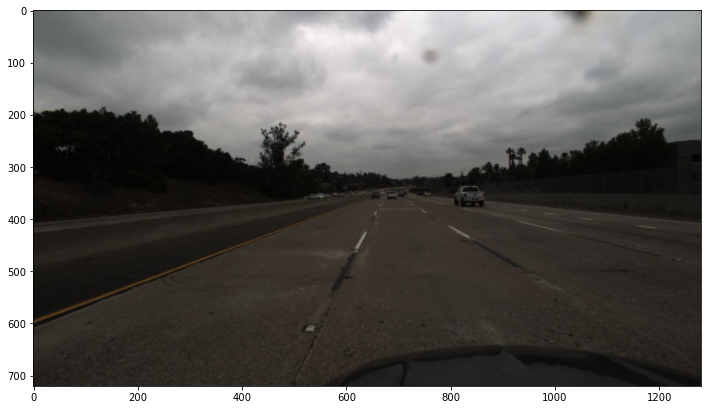

In [50]:
# Load a sample image.
# path = 'test_images/'
path = "C:/Users/alex/Desktop/2021T1/comp9517/ass2/clips/2/imgs/040.jpg"
img = mpimg.imread(path)
print('Shape:', img.shape)
plot_image(img, (10, 10))

## Raw SSD output: multiple detections after simple thresholding

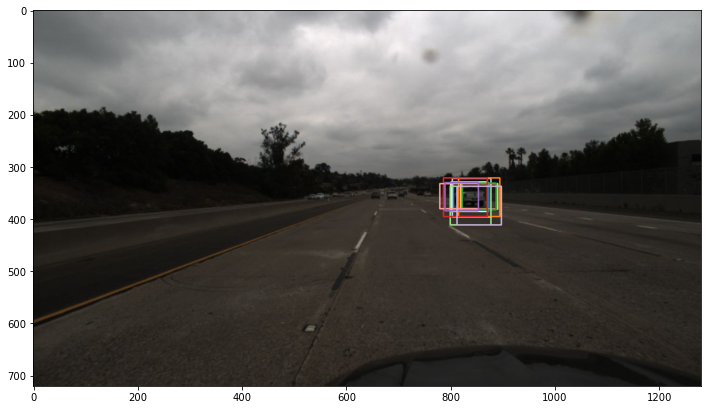

In [51]:
# SSD network on image.
rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
# Draw bboxes of detected objects.
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)

plot_image(img_bboxes, (10, 10))

(-0.5, 1279.5, 719.5, -0.5)

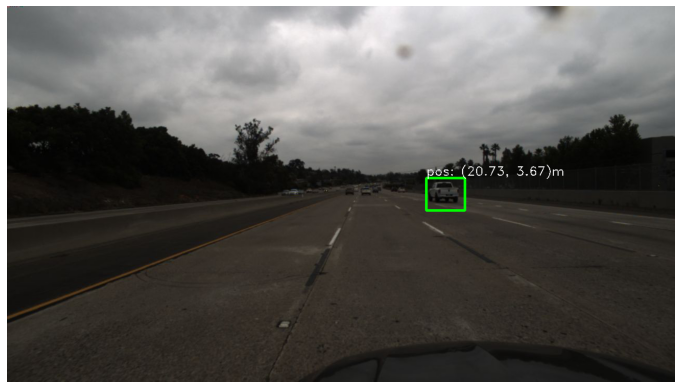

In [52]:
# Apply Non-Maximum-Selection
nms_threshold = 0.5
rclasses_nms, rscores_nms, rbboxes_nms = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)

output_bbox = bboxes_convert(img, rbboxes_nms)

focal_length = (714.1526 + 710.3725) / 2
real_width = 2.154184483121644
cx = 713.85
tmp_x = []
tmp_y = []
for bbox in output_bbox:
    x1 = float(bbox[0][0])
    y1 = float(bbox[0][1])
    x2 = float(bbox[1][0])
    y2 = float(bbox[1][1])
    pixel_width = x2 - x1
    avg = (x1 + x2) / 2
    distance = focal_length * real_width / pixel_width
    offset = distance *  (avg - cx) / focal_length
    tmp_x.append(distance)
    tmp_y.append(offset)

# Draw bboxes
img_bboxes = np.copy(img)
draw_position(img_bboxes, tmp_x, tmp_y, rbboxes_nms, colors_tableau, thickness=4)

plot_image(img_bboxes, (10, 10))
plt.axis('off') 
# plt.savefig('output.jpg')

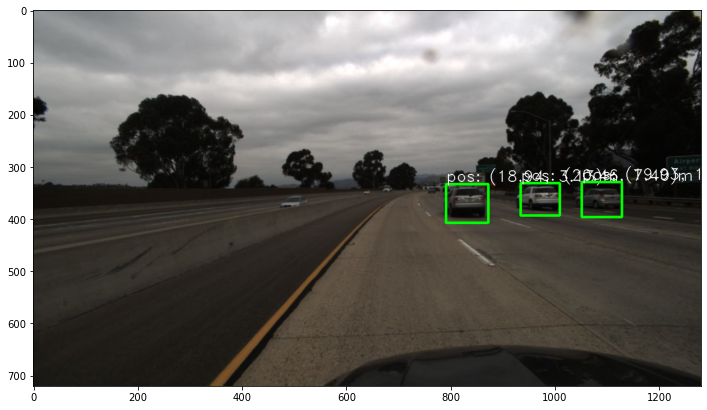

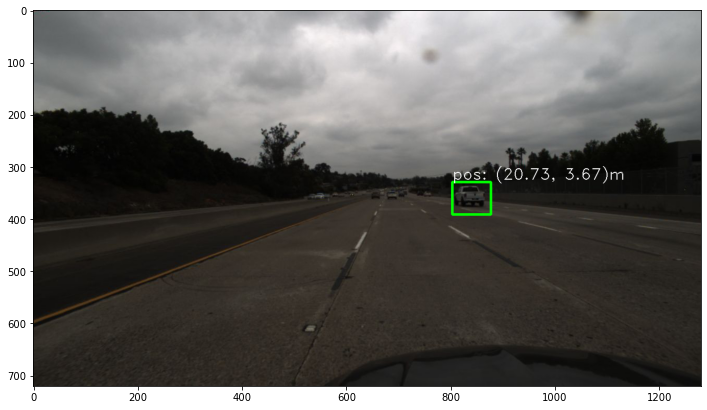

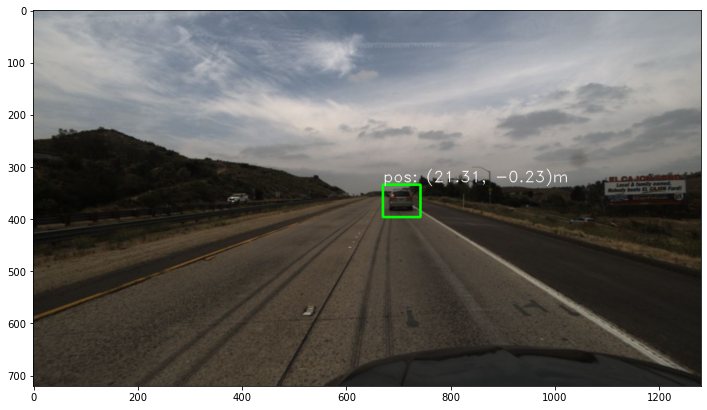

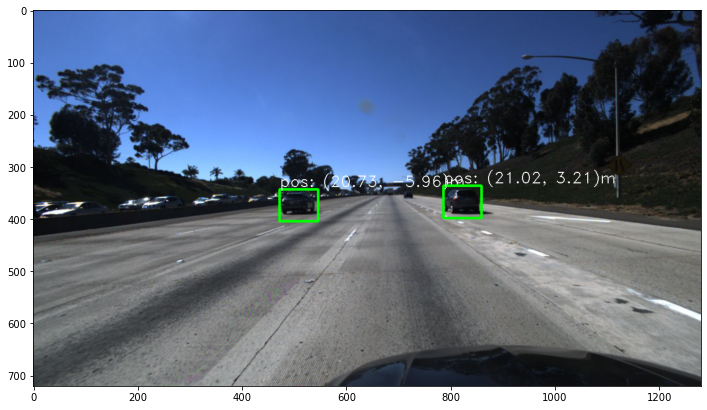

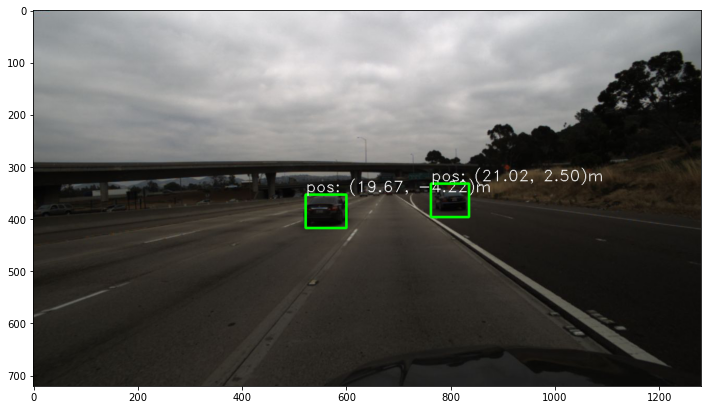

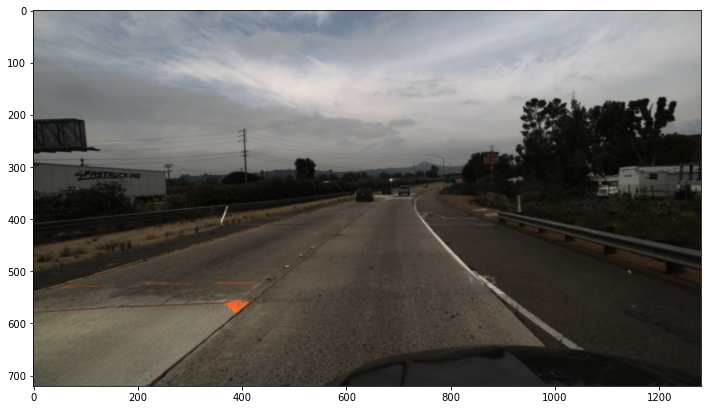

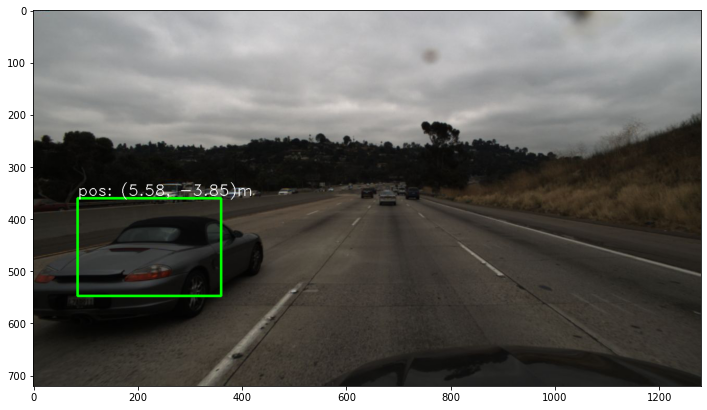

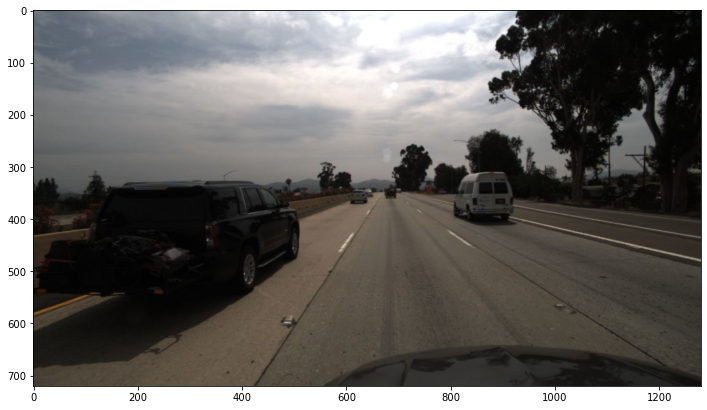

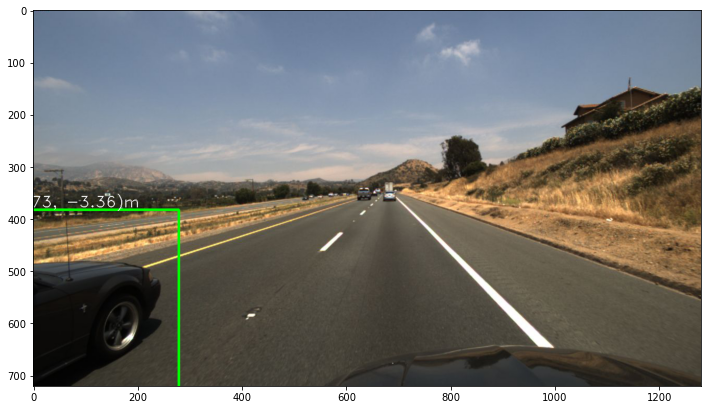

In [47]:
for i in [1,2,4,7,17,3,29,47,49]:    
    # Load a sample image.
    # path = 'test_images/'
    path = os.path.join("clips", str(i), "imgs/040.jpg")
    img = mpimg.imread(path)
#     plot_image(img, 'Original frame', (10, 10))


    # SSD network on image.
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
    # Draw bboxes of detected objects.
    img_bboxes = np.copy(img)
    bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)
#     plot_image(img_bboxes, 'Raw SSD network output: multiple detections.', (10, 10))


    # Apply Non-Maximum-Selection
    nms_threshold = 0.5
    rclasses_nms, rscores_nms, rbboxes_nms = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)

    output_bbox = bboxes_convert(img, rbboxes_nms)

    focal_length = (714.1526 + 710.3725) / 2  # average of fx and fy
    real_width = 2.154184483121644            # We compute it using all of the annotations in the training dataset
    cx = 713.85
    tmp_x = []
    tmp_y = []
    for bbox in output_bbox:
        x1 = float(bbox[0][0])
        y1 = float(bbox[0][1])
        x2 = float(bbox[1][0])
        y2 = float(bbox[1][1])
        pixel_width = x2 - x1
        avg = (x1 + x2) / 2
        distance = focal_length * real_width / pixel_width
        offset = distance *  (avg - cx) / focal_length
        tmp_x.append(distance)
        tmp_y.append(offset)

    # Draw bboxes
    img_bboxes = np.copy(img)
    draw_position(img_bboxes, tmp_x, tmp_y, rbboxes_nms, colors_tableau, thickness=4)
    plot_image(img_bboxes, (10, 10))

In [71]:
def get_position(num):
    json_path = os.path.join("clips", str(num), "annotation.json")
    strList = json.load(open(json_path))
    output = []
    for i in range(0,len(strList)):
        position = strList[i].get('position')
        position_x = position[0]
        position_y = position[1]
        bbox = strList[i].get('bbox')
        y1 = float(bbox.get('top'))
        x2 = float(bbox.get('right'))
        y2 = float(bbox.get('bottom'))
        x1 = float(bbox.get('left'))
        w1 = x2 - x1
        h1 = y2 - y1
        output.append([x1, y1, w1, h1, position_x, position_y])
    return output

In [37]:
def get_the_average_width(num):
    json_path = os.path.join("clips", str(num), "annotation.json")
    
    strList = json.load(open(json_path))
    bbox = strList[0].get('bbox')
    y1 = float(bbox.get('top'))
    x2 = float(bbox.get('right'))
    y2 = float(bbox.get('bottom'))
    x1 = float(bbox.get('left'))
    width = x2 - x1
    position = strList[0].get('position')
    distance = position[0]
    return width, distance

focal_length = (714.1526 + 710.3725) / 2
summ = 0
for i in range(1,1075):
    width, distance = get_the_average_width(i)
    real_width = distance * width / focal_length
    summ += real_width
real_width = summ/1074
print("The average real width of the vehicles in the training dataset is",real_width)

The average real width of the vehicles in the training dataset is 2.154184483121644


# Evaluation 

    Evaluate the results by comparing the output position value with the position value in the annotations. We can get the mean absolute error of the distance.
    
    It performs well on most of images. However, there is still room for improvement.
    
    Future improvement
        ·In the case of bad light, some vehicles cannot be detected.
        ·Sometimes, the bounding boxes are a bit too large, resulting in inaccurate measurement of the distance
        ·We only consider the width of the vehicles, but actually in the images, Some cars were photographed sideways.
    

In [76]:
sum_x = 0
sum_y = 0
length = 0
no_detection = 0
output = []
real_width = 2.154184483121644
# real_width = 1.8
focal_length = (714.1526 + 710.3725) / 2
cx = 713.85
for i in range(1,1075):
    gt = get_position(i)
    path = os.path.join("clips", str(i), "imgs/040.jpg")
    img = mpimg.imread(path)
    # SSD network on image.
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
    # Draw bboxes of detected objects.
    img_bboxes = np.copy(img)
    bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)
    # Apply Non-Maximum-Selection
    nms_threshold = 0.5
    rclasses_nms, rscores_nms, rbboxes_nms = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Get the bbox value
    output_bbox = bboxes_convert(img, rbboxes_nms)
    
    for x0,y0,w0,h0,position_x, position_y in gt:
        tmp_x = []
        tmp_y = []
        if len(output_bbox) > 0:
            for bbox in output_bbox:
                x1 = float(bbox[0][0])
                y1 = float(bbox[0][1])
                x2 = float(bbox[1][0])
                y2 = float(bbox[1][1])
                w = x2 - x1
                h = y2 - y1
                x3 = max(x0,x1)
                y3 = max(y0,y1)
                x4 = min(x0+w0,x1+w)
                y4 = min(y0+h0,y1+h)
                if x3 >= x4 or y3 >= y4:
                    continue
                else:
                    pixel_width = x2 - x1
                    avg = (x1 + x2) / 2
                    distance = focal_length * real_width / pixel_width
                    offset = distance *  (avg - cx) / focal_length
                    x = np.abs(distance - position_x)
                    y = np.abs(offset - position_y)
#                     tmp_x.append(x)
#                     tmp_y.append(y)
                    length += 1
                    sum_y += y
                    sum_x += x
        else:
            no_detection += 1
print("Mean absolute error depth:", sum_x/length)
print("Mean absolute error horizontal displacement:", sum_y/length)
print("No vehicle detected images:",no_detection)

Mean absolute error depth: 7.964742459359323
Mean absolute error horizontal displacement: 0.8507224104033045
No vehicle detected images: 71
